## Train a neural network on heart failure data

###  Recap data preparation from last time

In [55]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

# look at heart failure data from last class
current_dir = os.getcwd()

heart_data = pd.read_csv("C:/Users/iandr/masters_coding/Second Semester/Data_Science/Data_Science_2/heart_train.csv")

features = heart_data.drop(columns=["HeartDisease"])
label = heart_data["HeartDisease"]

prng = np.random.RandomState(20240311)  # ensure we have the same split as in last class
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=prng)

### Estimate simple logistic regression as a benchmark

In [56]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# preprocess
one_hot_encoder = OneHotEncoder(sparse_output=False, drop="first")
categorical_vars = heart_data.select_dtypes(include="object").columns.to_list()

column_transformer = ColumnTransformer(
    [("create_dummies", one_hot_encoder, categorical_vars)],
    remainder="passthrough"
)

# pipeline with lgoit
pipe_logit = Pipeline([
    ("preprocess", column_transformer),
    ("scale", MinMaxScaler()),
    ("logit", LogisticRegression(penalty=None))
])
pipe_logit.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('create_dummies',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('scale', MinMaxScaler()),
                ('logit', LogisticRegression(penalty=None))])

### Evaluate the performance by AUC

In [57]:
from sklearn.metrics import roc_auc_score

predicted_probs = pipe_logit.predict_proba(X_test)[:, 1]
auc_score_test = roc_auc_score(y_test, predicted_probs)
print(f"AUC on the test set for simple logit is {round(auc_score_test, 4)}")

AUC on the test set for simple logit is 0.9484


### Estimate a neural network on the heart data

In [58]:
from sklearn.neural_network import MLPClassifier
pipe_mlp = Pipeline([
    ("preprocess", column_transformer),
    ("scale", MinMaxScaler()),
    ("MLP", MLPClassifier(random_state = prng))
])
pipe_mlp.fit(X_train, y_train)

C:\Users\iandr\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('create_dummies',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('scale', MinMaxScaler()),
                ('MLP',
                 MLPClassifier(random_state=RandomState(MT19937) at 0x1ED3F142A40))])

In [59]:
pipe_mlp["MLP"].get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': RandomState(MT19937) at 0x1ED3F142A40,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

## MLPClassifier Parameters Explanation

Below are the parameters of the `MLPClassifier` from scikit-learn, which is part of a pipeline object named `pipe_mlp`. Each parameter plays a crucial role in the neural network's architecture and learning process:

- `activation`: The activation function for the hidden layers. `'relu'` stands for the rectified linear unit function, a popular choice due to its simplicity and efficiency in deep learning models. Can also be `sigmoid`

- `alpha`: L2 penalty (regularization term) parameter. `0.0001` is a small regularization strength which prevents overfitting by penalizing large weights.

- `batch_size`: Size of minibatches for stochastic optimizers. `'auto'` means that the batch size is set to `min(200, n_samples)` where `n_samples` is the number of samples in the training dataset.

- `beta_1` & `beta_2`: Parameters for the Adam optimizer. `beta_1` is the exponential decay rate for the first moment estimates, and `beta_2` is for the second moment estimates. These are part of the adaptive learning rate techniques, helping the optimizer to converge faster.

- `early_stopping`: Whether to use early stopping to terminate training when validation score is not improving. `False` means it is not used, which can sometimes lead to overfitting on the training dataset.

- `epsilon`: Value for numerical stability in Adam optimizer. `1e-08` is a very small number to prevent any division by zero in the implementation.

- `hidden_layer_sizes`: Tuple representing the number of neurons in the hidden layers. `(100,)` means there is one hidden layer with 100 neurons.

- `learning_rate`: Type of learning rate schedule. `'constant'` keeps the learning rate constant as set by `learning_rate_init`.

- `learning_rate_init`: The initial learning rate when the learning schedule is `'constant'`. `0.001` is a typical starting rate, providing a balance between speed and stability of learning.

- `max_fun`: Maximum number of loss function calls. The solver iterates until convergence (as determined by `tol`) or this number of loss function calls. `15000` is quite high, allowing for complex models to converge, given enough iterations.

- `max_iter`: Maximum number of iterations. The solver iterates until convergence (as determined by `tol`) or this number of iterations. `200` is a standard default value.

- `momentum`: Momentum for gradient descent update. `0.9` is very common and helps to accelerate gradients vectors in the right directions, thus leading to faster converging.

- `n_iter_no_change`: Maximum number of epochs to not meet `tol` improvement. Used only with `early_stopping=True`.

- `nesterovs_momentum`: Whether to use Nesterov’s momentum. `True` means using this advanced form of momentum which can accelerate training.

- `power_t`: The exponent for inverse scaling learning rate. It is used in updating effective learning rate when the learning_rate is set to `'invscaling'`.

- `random_state`: The seed of the pseudo random number generator to use when shuffling the data. `RandomState(MT19937)` indicates a specific state for reproducibility of results.

- `shuffle`: Whether to shuffle samples in each iteration. `True` means that the dataset will be shuffled before each epoch, which helps prevent the model from memorizing the order of samples.

- `solver`: The solver for weight optimization. `'adam'` is an efficient stochastic gradient descent algorithm that is widely used in training deep learning models.

- `tol`: Tolerance for the optimization. When the loss or score is not improving by at least this much, the training stops. `0.0001` is a small value that allows for fine-grained control over when the algorithm stops.

- `validation_fraction`: The proportion of training data to set aside as validation set for early stopping. `0.1` means 10% of training data is used for validation.

- `verbose`: Whether to print progress messages to stdout. `False` means no verbose output.

- `warm_start`: When set to `True`, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. `False` means starting fresh each time.


In [60]:
predicted_probs_mlp = pipe_mlp.predict_proba(X_test)[:, 1]
auc_score_test_mlp = roc_auc_score(y_test, predicted_probs_mlp)
print(f"AUC on the test set for basic MLP is {round(auc_score_test_mlp, 4)}")

AUC on the test set for basic MLP is 0.9529


This is better than the logit, while the 95.29 for the MLP is better than the value given from the logit. 

## Image recognition with neural networks

### Data

In [61]:
from keras.datasets import mnist

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Look at the dimensions
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")

X_train: (60000, 28, 28)
y_train: (60000,)
X_test:  (10000, 28, 28)
y_test:  (10000,)


In [62]:
# Note that we work here with numpy arrays instead of pandas dataframes
type(X_train)

numpy.ndarray

*It is really easy to score into a numpy array since we can have as many dimensions as we want through this*

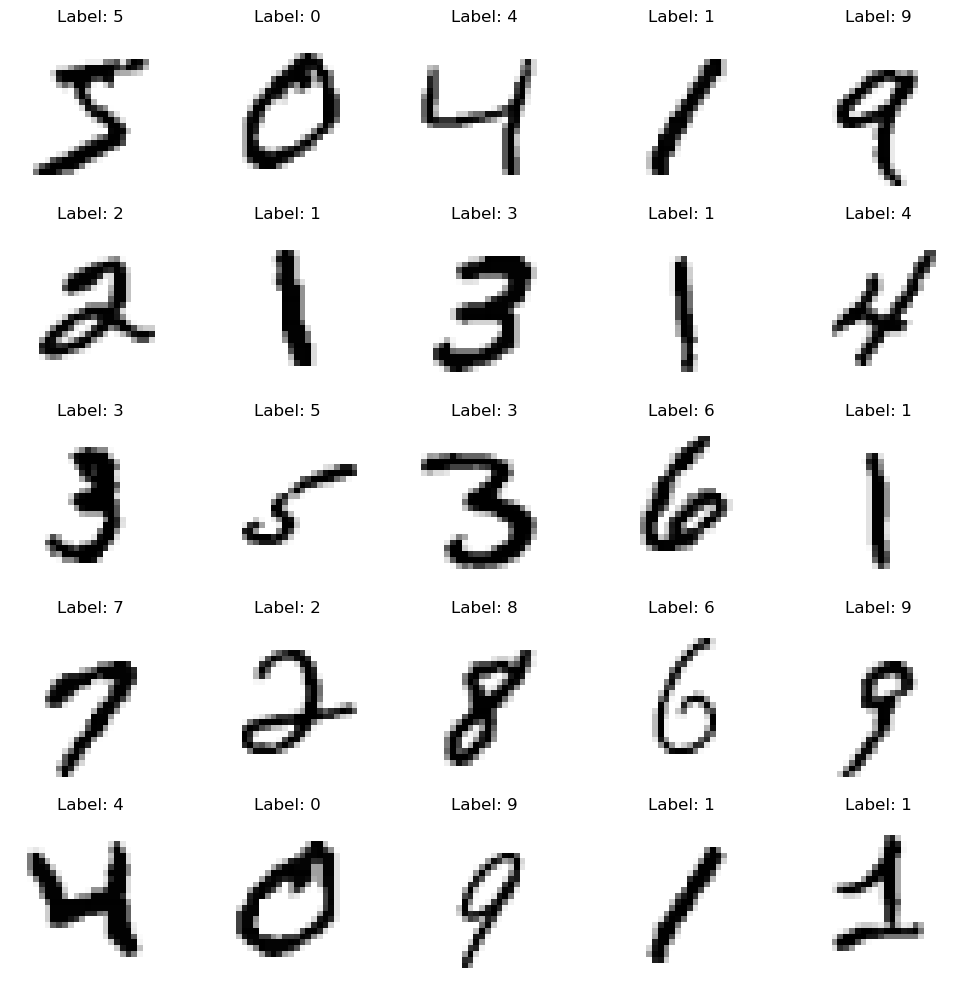

In [63]:
# Visualize some items in a grid
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_train[i], cmap="binary")
    ax.axis("off")
    ax.set_title(f"Label: {y_train[i]}")
plt.tight_layout()
plt.show()

The images above are super low quality images, but contain a large amount of informations for what we have to deal with so far. 

In [64]:
X_train[0,]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

We can see that these are two dimensional arraws and shows us the pixel intensity, which goes from 0 to 255

### Train/validation/test sets

We use three different sets because on the train set, we train a model with specific parameters. Then we evaluate this set on a different set, kind of like the validation set, and then we choose our best model based on this. But, why are we doing these comparisons of evalutations? For model selection, we use the validation set. So, we can still overfit our best model on the validation set, so we have to make sure we still have something we did not look at yet, which is the test set. That way, we will use the validation data to predict the test data. This way, we are not using the test data when choosing the best model. This is to allow us to avoid over fitting accidentally. We could choose the best model using cross-validation, but maybe tuning the hyperparameters, but then we should have a completely separate set that we have not used at all. 

In [65]:
# intentionally choose a small train set to decrease computational burden
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.8, random_state=prng)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val:  {X_val.shape}")
print(f"y_val:  {y_val.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")

X_train: (12000, 28, 28)
y_train: (12000,)
X_val:  (48000, 28, 28)
y_val:  (48000,)
X_test:  (10000, 28, 28)
y_test:  (10000,)


In machine learning, we divide our dataset into three distinct sets: training, validation, and test sets, to ensure that our model performs well not just on the data it was trained on, but also on new, unseen data. Here's a simpler breakdown of why each set is important:

1. Training Set: This is where the model learns. We use the training set to fit the model, adjusting its parameters to minimize errors. The model sees and learns from this data, so it's like the initial phase of studying.

2. Validation Set: Think of the validation set as a practice exam after studying. It helps us evaluate how well our model performs on data it hasn't seen before, without using the final test. We use this set to compare different models or configurations and select the best one. However, just like studying for a practice exam, there's a risk we might "overfit" our model to perform well on the validation set specifically, meaning it gets really good at answering these practice questions but might not perform well on different ones.

3. Test Set: Finally, the test set is like the final exam. It's a completely fresh set of data the model has never seen before. We use it only after we've chosen our best model using the training and validation sets. The performance on the test set gives us a true measure of how well our model will perform in the real world, on totally new data. By keeping this set separate and only using it at the very end, we ensure that our model's performance is genuinely effective and not just good at passing the tests it's seen before.

By using these three sets, we aim to build a model that not only learns well but can also apply what it's learned to new, unseen challenges effectively.




### Benchmarks

In [66]:
# Benchmark #1 (silly):

from sklearn.metrics import accuracy_score
from statistics import mode

most_frequent = mode(y_train)
print(f"Most frequent element is: {most_frequent}")
accuracy_most_frequent = accuracy_score(y_val, np.repeat(most_frequent, len(y_val)))
print(f"Accuracy for our no-brainer model: {round(accuracy_most_frequent, 4)}")

Most frequent element is: 1
Accuracy for our no-brainer model: 0.1119


We can train a state-of-the-art machine learning model almost as easily. It can be used as our second benchmark. Note that our train data is multidimensional, instead of having `k` features, we have `ixj` features. In order to apply a standard ML algorithm, we need to flatten our data first. 

Since we need to apply the flattening to both the train and the test data, a clever way to do this is to build this step into the pipeline. Since we are applying the transformation to the whole feature matrix rather than specific columns, we can use the `FunctionTransformer`, which can apply any user-defined function to the feature matrix.

In [67]:
# Benchmark #2 (RF):
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer

def flatten_data(X):
    return X.reshape(X.shape[0], -1)

# Step 1: Creating the pipeline
pipeline = Pipeline([
    ('flatten', FunctionTransformer(flatten_data)),
    ('model', RandomForestClassifier())
])

# Step 2: Fitting the pipeline
pipeline.fit(X_train, y_train)

# Step 3: Predicting classes on the validation set
predictions_rf = pipeline.predict(X_val)

# Step 4: Calculating accuracy
accuracy = accuracy_score(y_val, predictions_rf)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9523333333333334


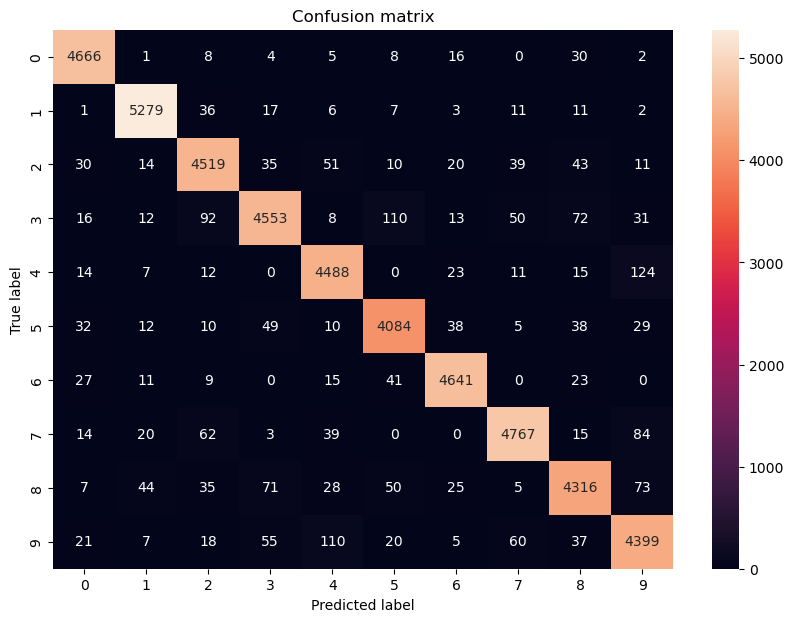

In [68]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, predictions_rf)

# # visualize with seaborn
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Sklearn MLP

In [71]:
def scale_features(X):
    return X / 255

# Step 1: Creating the pipeline
pipeline = Pipeline([
    ('flatten', FunctionTransformer(flatten_data)),
    ('scale', FunctionTransformer(scale_features)),
    ('model', MLPClassifier())
])

# Step 2: Fit the pipeline
pipeline.fit(X_train, y_train)

# Step 3: Predict on the validation set
y_pred = pipeline.predict(X_val)

# Step 4: Calculate the accuracy score
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9585


### Tensors

In machine learning, a tensor is a fancy term for a multi-dimensional array. Think of it as a container that can hold numbers in a structured grid that can have many dimensions. You're already familiar with some simpler forms of tensors:

- A scalar (a single number) can be thought of as a 0-dimensional tensor.
- A vector (a list of numbers) is a 1-dimensional tensor.
- A matrix (a table of numbers) is a 2-dimensional tensor.

Tensors become particularly handy when dealing with data that has more dimensions than these simple examples. For instance, color images can be represented as 3-dimensional tensors: height, width, and color channels (RGB).

In the context of neural networks, tensors are used for several reasons:

- Data Representation: Inputs, outputs, and even the weights within the network are represented as tensors. For example, an image might be input as a 3D tensor, and batches of such images would form a 4D tensor.
- Operations: Neural networks involve lots of mathematical operations (like addition, multiplication), and these operations can efficiently work on tensors. This efficiency is especially crucial for deep learning, where operations on large datasets and complex models can be computationally expensive.

Neurons, on the other hand, are the basic units of computation in a neural network. You can think of a neuron as a tiny worker that does a simple job:

- It takes some inputs (numbers).
- It does a little math with them (usually multiplying inputs by weights and adding a bias).
- It decides whether the result is interesting enough to pass on (using an activation function).
- Each neuron contributes a small part to the overall task the network is trying to learn, like recognizing cats in photos or predicting weather patterns. When lots of neurons work together in layers, forming a neural network, they can capture complex patterns and solve intricate problems.

So, in summary, a tensor is like the paper on which all the calculations are written, while neurons are like the workers doing the calculations, following instructions (the model's architecture and weights) to solve a problem.

### Keras: simple model

Keras builds on tensors and makes life easier.

While `scikit-learn` provides a wide range of machine learning algorithms, `keras` is specifically designed for building and training neural networks and deep learning models, making it more suitable for tasks involving complex patterns and large datasets. It offers several advanced features that `sklearn` does not, such as training networks with complex architectures (such as convolutional neural networks), or applying pre-processing techniques common to deep learning (such as scaling and flattening), or the ability to transfer learning from pre-trained networks.

Keras is a high-level neural network API that provides a simple and intuitive interface for building and training deep learning models. Keras can run on multiple backends, with TensorFlowTensor becoming the default. TensorFlow is a standalone, low-level deep learning library developed by Google.

In [22]:
from keras import __version__ as keras_version
print(keras_version)

3.0.5


In [24]:
from tensorflow.keras.utils import to_categorical

In [25]:
# Convert target variables to categorical
num_classes = 10
y_sets = [y_train, y_test, y_val]
y_train, y_test, y_val = [to_categorical(y, num_classes=num_classes) for y in y_sets]

In [26]:
from keras.models import Sequential
from keras.layers import Input, Flatten, Rescaling, Dense
from keras.utils import to_categorical

# Build the model
# sequential takes a list of items, but not tuples like the Pipeline does
model = Sequential([
    Input(shape=X_train.shape[1:]), # this tells us the shape of the input layer, and we need to reshape first before applyiing the model, but we can define it here
    Flatten(), 
    Rescaling(1./255), 
    Dense(100, activation='relu'), #dense means every node is connected to every previous node
    Dense(num_classes, activation='softmax') # everything is between 0 and 1
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# metrics are calculated, and we would like to see those in the output
print(model.summary())
# 784*100+100
# 100*10+10

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

None


### Compiling the Model 

CODE: model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

1. model.compile(...): This method prepares the model for training. In the context of TensorFlow or Keras (a high-level neural networks API, now integrated into TensorFlow), compiling the model means setting it up with the necessary configurations like the loss function, optimizer, and metrics to monitor during training and evaluation.

2. loss='categorical_crossentropy': The loss function is a measure of how well the model is performing, or more specifically, how far off its predictions are from the actual labels. categorical_crossentropy is a common choice when you're doing classification tasks involving multiple classes that are one-hot encoded. It quantifies the difference between the predicted probabilities and the actual distribution (the true labels).

3. optimizer='adam': The optimizer is an algorithm for adjusting the weights of the network to minimize the loss function. The adam optimizer is widely used because it combines the best properties of the AdaGrad and RMSProp algorithms to handle sparse gradients on noisy problems. Adam is efficient in terms of computation and requires little memory, making it a good choice for many types of neural networks.

4. metrics=['accuracy']: Metrics are used to evaluate the performance of your model. They are not used for training but give you insight into how well your model is doing. Here, accuracy is specified as a metric, meaning after each epoch (a full pass through the entire training dataset), the model will calculate how many of the training examples were correctly predicted.

So, in simple terms, this line of code tells the model:

- What to minimize (categorical_crossentropy), meaning it should try to get its predictions as close as possible to the true labels.
- How to minimize it (adam), meaning it will use the Adam algorithm to adjust its internal parameters (weights) to reduce the loss.
- How to measure its performance (accuracy), meaning it will keep track of how many predictions it gets right.

The core of the backend is indeed constructed around **tensors**. Tensors are akin to NumPy arrays, as they hold numerical values of different dimensions. What sets them apart is their specialized role in deep learning: they are equipped with built-in gradient computation, seamlessly integrate within a computational graph, and are capable of leveraging hardware accelerators like TPUs and GPUs.

In [27]:
model.layers[3].output

<KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_4>

In [29]:
import keras

In [30]:
# Fit the model
keras.utils.set_random_seed(20240318)  # for reproducibility
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=512)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4949 - loss: 1.7834 - val_accuracy: 0.8211 - val_loss: 0.7450
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8399 - loss: 0.6378 - val_accuracy: 0.8788 - val_loss: 0.4544
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8887 - loss: 0.4238 - val_accuracy: 0.8969 - val_loss: 0.3749
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9063 - loss: 0.3530 - val_accuracy: 0.9064 - val_loss: 0.3357
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9154 - loss: 0.3133 - val_accuracy: 0.9134 - val_loss: 0.3104
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9231 - loss: 0.2849 - val_accuracy: 0.9180 - val_loss: 0.2922
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9299 - loss: 0.2627 - val_accuracy: 0.9222 - val_loss: 0.2777
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9346 - loss: 0.2440 - val_accuracy: 0.9252 - val_lo

In 24 batches, we interate through the whole training set. The 24 is the number of batches. 

In [31]:
# Evaluation of the model on the validation set
scores = model.evaluate(X_val, y_val)
print(f"Accuracy for keras MLP: {round(scores[1], 4)}")

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9296 - loss: 0.2476
Accuracy for keras MLP: 0.93


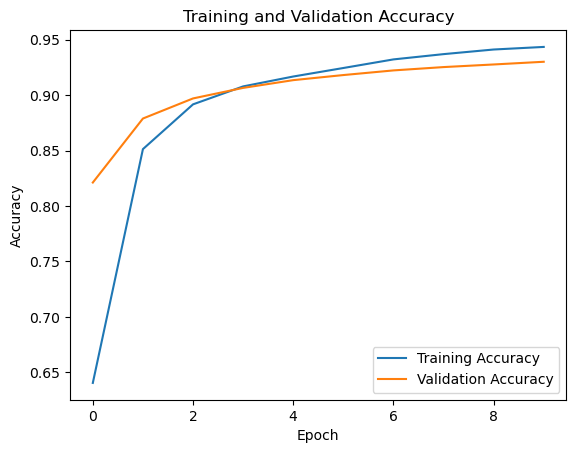

In [32]:
def plot_history(fit_history):
    plt.plot(fit_history['accuracy'], label='Training Accuracy')
    plt.plot(fit_history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

plot_history(history.history)

It seems that the maximum is not yet found. Let's train the network a little bit longer. Note that unless we recreate the model, the process starts from the point where it previously ended.

In [33]:
# TODO: run for at least 50 epochs, store the result in history_longer_train
history_longer_train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=512)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9449 - loss: 0.2000 - val_accuracy: 0.9324 - val_loss: 0.2390
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9475 - loss: 0.1883 - val_accuracy: 0.9339 - val_loss: 0.2321
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9513 - loss: 0.1776 - val_accuracy: 0.9353 - val_loss: 0.2258
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9546 - loss: 0.1678 - val_accuracy: 0.9366 - val_loss: 0.2202
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9578 - loss: 0.1587 - val_accuracy: 0.9377 - val_loss: 0.2150
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9605 - loss: 0.1503 - val_accuracy: 0.9388 - val_loss: 0.2106
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9628 - loss: 0.1427 - val_accuracy: 0.9399 - val_loss: 0.2067
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9643 - loss: 0.1355 - val_accuracy: 0.9406 - va

In [34]:
total_history = {
    "accuracy": history.history["accuracy"] + history_longer_train.history["accuracy"],
    "val_accuracy": history.history["val_accuracy"] + history_longer_train.history["val_accuracy"],
}

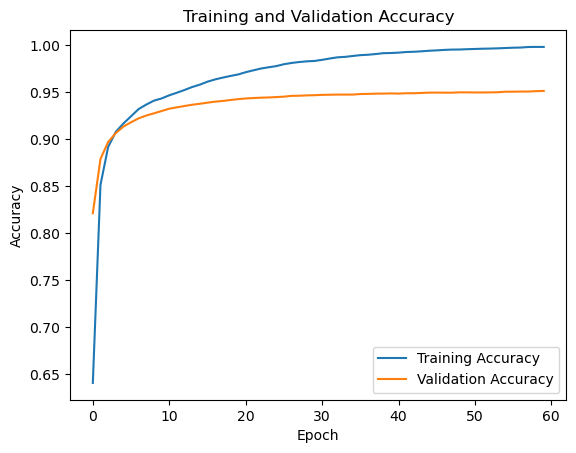

In [35]:
plot_history(total_history)

In [36]:
model.evaluate(X_val, y_val)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - accuracy: 0.9519 - loss: 0.1728


[0.1762784868478775, 0.9513333439826965]

### Regularization in neural networks

#### Early stopping

We already saw this when growing a tree. Defining the depth of a tree, so stop growing it anymore if there is no improvement. So, whenever something does not improve anymore, stop it. 

This works here in the epochs by stopping the epochs whenever it cannot improve anymore

In [37]:
from keras.callbacks import EarlyStopping
from keras.models import clone_model

# to make sure the process starts over, we need to create a new model instanse and compile it
cloned_model = clone_model(model)
cloned_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit with early stopping
history_with_early_stopping = cloned_model.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=512, 
    callbacks=[EarlyStopping(monitor='val_accuracy')] # here is the EarlyStopping funciton, dependent on the validation set. 
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4859 - loss: 1.7695 - val_accuracy: 0.8273 - val_loss: 0.7258
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8432 - loss: 0.6252 - val_accuracy: 0.8806 - val_loss: 0.4473
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8886 - loss: 0.4152 - val_accuracy: 0.8987 - val_loss: 0.3682
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9081 - loss: 0.3439 - val_accuracy: 0.9089 - val_loss: 0.3277
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9169 - loss: 0.3031 - val_accuracy: 0.9154 - val_loss: 0.3017
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9231 - loss: 0.2739 - val_accuracy: 0.9209 - val_loss: 0.2827
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9299 - loss: 0.2511 - val_accuracy: 0.9249 - val_loss: 0.2680
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9367 - loss: 0.2323 - val_accuracy: 0.9278 - va

We can see the val_accuracy stopped improving at 0.9491

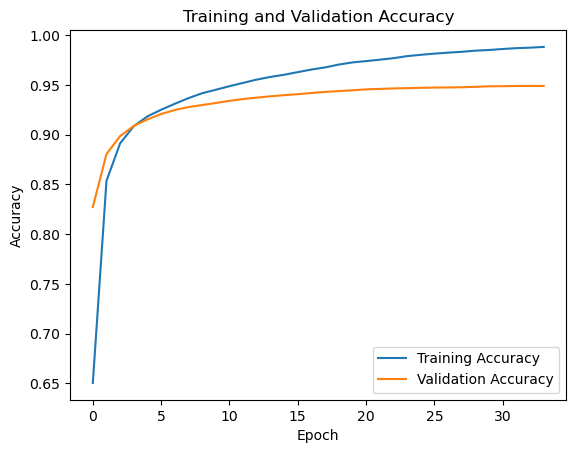

In [38]:
plot_history(history_with_early_stopping.history)

Here, it'S kind of converging a bit, but not entirely. Could be optimized better. 

#### Dropout

In [39]:
from keras.layers import Dropout

# Build the model
regularized_model = Sequential([
    Input(shape=X_train.shape[1:]),
    Flatten(),
    Rescaling(1./255),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
regularized_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(regularized_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

None


In [40]:
history_regularized = regularized_model.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=512,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=2)] # two epochs without any improvement is still fine
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3065 - loss: 2.0273 - val_accuracy: 0.8070 - val_loss: 0.8876
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7195 - loss: 0.9503 - val_accuracy: 0.8642 - val_loss: 0.5398
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8042 - loss: 0.6623 - val_accuracy: 0.8896 - val_loss: 0.4305
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8440 - loss: 0.5450 - val_accuracy: 0.8998 - val_loss: 0.3750
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8652 - loss: 0.4831 - val_accuracy: 0.9069 - val_loss: 0.3418
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8710 - loss: 0.4429 - val_accuracy: 0.9120 - val_loss: 0.3173
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8838 - loss: 0.4131 - val_accuracy: 0.9171 - val_loss: 0.2990
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8893 - loss: 0.3898 - val_accuracy: 0.9208 - val_

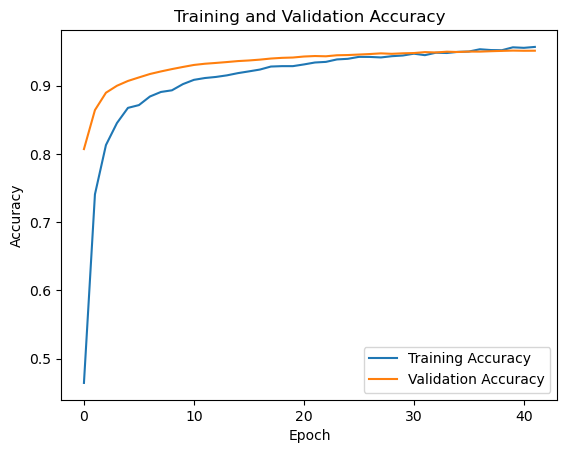

In [41]:
plot_history(history_regularized.history)

### Keras: Deep network

In [42]:
# Build the model
deep_model = Sequential([    
    Input(shape=X_train.shape[1:]),
    Flatten(),
    Rescaling(1./255),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the deep_model
deep_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(deep_model.summary())
# 784*256+256
# 256*256+256
# 256*10+10

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,322 (1.03 MB)

 Trainable params: 269,322 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

None


In [43]:
history_deep = deep_model.fit(
    X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=512,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=2)]
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3577 - loss: 1.8875 - val_accuracy: 0.8472 - val_loss: 0.5375
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7662 - loss: 0.7114 - val_accuracy: 0.8952 - val_loss: 0.3656
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8520 - loss: 0.4856 - val_accuracy: 0.9138 - val_loss: 0.2935
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8770 - loss: 0.3942 - val_accuracy: 0.9223 - val_loss: 0.2602
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8958 - loss: 0.3451 - val_accuracy: 0.9295 - val_loss: 0.2360
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9071 - loss: 0.3021 - val_accuracy: 0.9334 - val_loss: 0.2205
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9167 - loss: 0.2788 - val_accuracy: 0.9379 - val_loss: 0.2043
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9198 - loss: 0.2595 - val_accuracy: 0.9421 - v

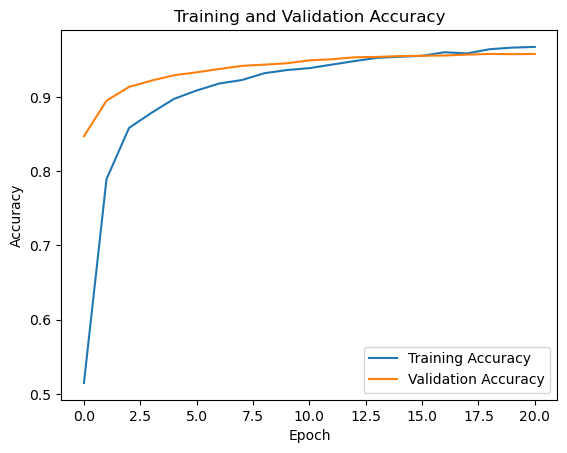

In [44]:
plot_history(history_deep.history)

### Convolution with keras

Convolutional layers are designed to operate on images or time-series data with multiple sensors, so they expect input data to have a channel dimension. In our case, since we are dealing with grayscale images, we will have only one channel (unlike the RGB channels in color images). To ensure our data has this channel dimension, we need to reshape our data first. Let's collect all the preprocessing steps, and create new preprocessed sets.

In [45]:
from keras.layers import Reshape

preprocess = Sequential([
    Reshape(target_shape=(X_train.shape[1], X_train.shape[2], 1)),  # explicitly state the 4th (channel) dimension
    Rescaling(1./255)
])

X_sets = [X_train, X_test, X_val]
X_train_4D, X_test_4D, X_val_4D = [preprocess(X) for X in X_sets]

In [46]:
X_train.shape

(12000, 28, 28)

In [47]:
X_train_4D.shape

TensorShape([12000, 28, 28, 1])

The fourth dimension within one sample is 1

In [48]:
from keras.layers import Conv2D, MaxPooling2D

# Build the model
model_cnn = Sequential([
    Input(shape=X_train_4D.shape[1:]),
    Conv2D(32, (3, 3), activation='relu'), # 32 different types of kernals
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_cnn.summary())
# 32*(3*3+1)
# 64*(32*3*3+1) -- bias term is not channel-specific as it does not depend on the input data
# (64*5*5)*10+10

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [49]:
# Fit the model
history_cnn = model_cnn.fit(
    X_train_4D, y_train, validation_data=(X_val_4D, y_val), epochs=50, batch_size=512,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=2)]
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.3390 - loss: 2.1195 - val_accuracy: 0.7844 - val_loss: 1.0434
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.7339 - loss: 0.8935 - val_accuracy: 0.8824 - val_loss: 0.4097
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.8461 - loss: 0.4776 - val_accuracy: 0.9139 - val_loss: 0.2936
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.8971 - loss: 0.3346 - val_accuracy: 0.9350 - val_loss: 0.2240
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9207 - loss: 0.2545 - val_accuracy: 0.9462 - val_loss: 0.1838
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9331 - loss: 0.2177 - val_accuracy: 0.9542 - val_loss: 0.1584
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9435 - loss: 0.1877 - val_accuracy: 0.9591 - val_loss: 0.1401
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9486 - loss: 0.1707 - val_accuracy: 0.

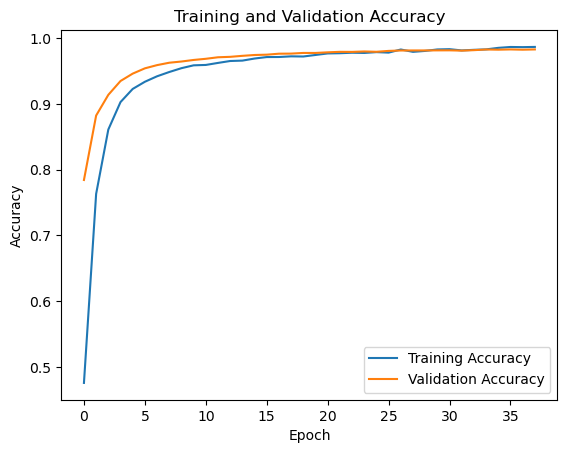

In [50]:
plot_history(history_cnn.history)

We can see that now the training and validation accuracy is around the same. But we need more data. We could do bagging, but it would not really make a lot of sense to randomize the data. So we can do something called data augmentation which uses shifting. 

### Other useful tricks: data augmentation

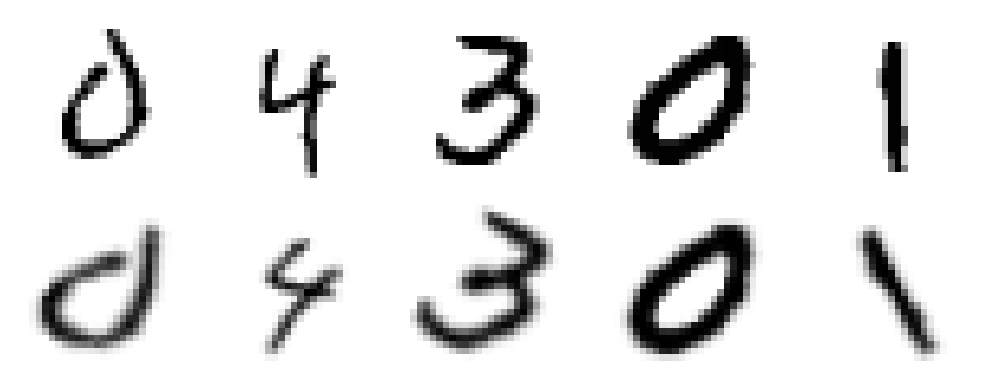

In [51]:
from keras.layers import RandomRotation, RandomZoom

# TODO: Create a new Sequential model called data augmentation with two layers: 
    # RandomRotation(0.1, fill_mode="nearest") & RandomZoom(0.2, fill_mode="nearest")
    
# generating new data without having to collect new data
data_augmentation = Sequential([
    RandomRotation(0.1, fill_mode="nearest"),
    RandomZoom(0.2, fill_mode="nearest") 
])

# Look at the transformations
number_of_digits_to_show = 5
fig, axs = plt.subplots(2, number_of_digits_to_show, figsize=(2*number_of_digits_to_show, 4))
for _ in range(number_of_digits_to_show):
    axs[0, _].imshow(X_train_4D[_], cmap="binary")
    axs[0, _].axis("off")
    axs[1, _].imshow(data_augmentation(X_train_4D[_]), cmap="binary")
    axs[1, _].axis("off")
plt.tight_layout()
plt.show()

In [52]:
model_cnn_da = Sequential([
    data_augmentation,
    model_cnn
])

print(model_cnn_da.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ ?                      │        34,826 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [53]:
# Compile the model
model_cnn_da.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cnn_da = model_cnn_da.fit(
    X_train_4D, y_train, validation_data=(X_val_4D, y_val), epochs=50, batch_size=512,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5)] # increase patience for slower learning
)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.1211 - loss: 3.0446 - val_accuracy: 0.9607 - val_loss: 0.2919
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.1154 - loss: 2.4190 - val_accuracy: 0.9464 - val_loss: 0.7601
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.1201 - loss: 2.3146 - val_accuracy: 0.9319 - val_loss: 1.0400
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.1168 - loss: 2.3052 - val_accuracy: 0.9188 - val_loss: 1.2316
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.1183 - loss: 2.3012 - val_accuracy: 0.9081 - val_loss: 1.3820
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.1124 - loss: 2.3020 - val_accuracy: 0.9005 - val_loss: 1.4731


### Evaluate our final model on the test set

In [85]:
# If X_test is not already in 4D shape, adjust it. Assuming `X_test` needs to be reshaped:
# X_test_4D = X_test.reshape(-1, img_height, img_width, num_channels)

# Ensure y_test is one-hot encoded
from tensorflow.keras.utils import to_categorical
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

# Then, evaluate the model
model_cnn_da.evaluate(X_test_4D, y_test_categorical)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9081 - loss: 1.4551


[1.470674753189087, 0.9086999893188477]

## Transfer learning

In [74]:
from keras.utils import load_img, img_to_array
from keras.applications.resnet50 import ResNet50

pretrained_model = ResNet50(weights='imagenet')
print(pretrained_model.summary())

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

None


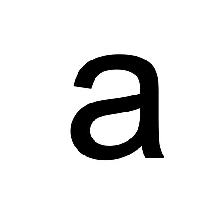

In [100]:
img_path = "C:/Users/iandr/masters_coding/th-4040432956.jpeg"
img = load_img(img_path, target_size=(224, 224))
img

In [101]:
x = img_to_array(img)
x.shape

(224, 224, 3)

In [102]:
# make sure it is one sample with 3 dimensions
x = np.expand_dims(x, axis=0)
x.shape

(1, 224, 224, 3)

In [103]:
preds = pretrained_model.predict(x)
preds.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


(1, 1000)

In [104]:
preds

array([[1.11860857e-06, 1.61827450e-06, 6.47960462e-07, 6.26820054e-08,
        7.20478829e-06, 3.91550595e-04, 1.86810453e-07, 1.13474584e-06,
        3.38266295e-06, 1.71962820e-05, 1.21592507e-06, 3.47992170e-07,
        8.45877821e-07, 7.43345367e-07, 1.28710724e-07, 1.19169372e-05,
        1.35235559e-05, 5.25407415e-07, 2.09643786e-05, 8.97240056e-07,
        2.41583820e-07, 4.61337368e-06, 6.72378428e-06, 2.79338092e-05,
        2.73971136e-06, 8.23484697e-06, 7.44345925e-06, 3.98111297e-04,
        2.09574341e-06, 6.13386533e-07, 3.10069311e-07, 1.05733172e-07,
        9.96340987e-07, 2.92116482e-08, 9.42511360e-06, 2.19915265e-07,
        1.31495739e-07, 5.41761096e-07, 7.48544562e-06, 9.33068463e-07,
        7.62622130e-06, 3.20935828e-06, 1.08046106e-06, 3.45160083e-06,
        2.12755094e-06, 3.04067544e-06, 1.74541697e-06, 4.88131172e-06,
        2.43257500e-06, 3.44929454e-08, 1.41148962e-06, 7.18147567e-05,
        2.01317263e-04, 5.49878983e-04, 7.49824858e-06, 3.558375

In [105]:
from keras.applications.resnet50 import decode_predictions
decoded_preds = decode_predictions(preds, top=3)
[(i[1], round(i[2], 4)) for i in decoded_preds[0]]

[('hook', 0.396), ('nematode', 0.1099), ('nail', 0.0685)]

We can fine-tune these pre-trained models for our purposes by modifying the last few layers, and learn only the new parameters on new data (freezing the weights of the original network). See e.g [this tutorial](https://pyimagesearch.com/2020/04/27/fine-tuning-resnet-with-keras-tensorflow-and-deep-learning/) for more details.